In [96]:
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [97]:
data = pd.read_csv('tess-table.csv')

data = data[data['tfopwg_disp'] != 'FA' ]
data = data[data['tfopwg_disp'] != 'FP']
data = data[data['tfopwg_disp'] != 'APC']
#known planets to 0
data.loc[data['tfopwg_disp'] == 'KP', 'tfopwg_disp'] = 0
#confirmed and candidates as 1 (exoplanet class)
data.loc[data['tfopwg_disp'] == 'CP', 'tfopwg_disp'] = 1
data.loc[data['tfopwg_disp'] == 'PC', 'tfopwg_disp'] = 1

data['tfopwg_disp'] = data['tfopwg_disp'].astype('int64')

In [98]:
#non-numerical data/or data that hard to convert
#feature data-frame
X = data.drop(columns=['toi', 'tid', 'toi_created', 'rowupdate', 'decstr', 'rastr'])
#label column
y = X.pop('tfopwg_disp').astype('float64')

In [99]:
#split training set/validation set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.2,
                                    random_state=1)

features_num = [
    'ra', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt',
    'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad'
]
features_cat = []

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)

transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [100]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    #1 layer
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),
    #2 layer
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),
    #3 layer
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),
    #4 layer
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),
    #output layer
    layers.Dense(1, activation='sigmoid')
])

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [101]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - binary_accuracy: 0.6513 - loss: 0.6915 - val_binary_accuracy: 0.9041 - val_loss: 0.3603
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - binary_accuracy: 0.8303 - loss: 0.4241 - val_binary_accuracy: 0.9066 - val_loss: 0.3237
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - binary_accuracy: 0.8732 - loss: 0.3533 - val_binary_accuracy: 0.9066 - val_loss: 0.2833
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - binary_accuracy: 0.8866 - loss: 0.3223 - val_binary_accuracy: 0.9066 - val_loss: 0.2708
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - binary_accuracy: 0.8982 - loss: 0.2920 - val_binary_accuracy: 0.9125 - val_loss: 0.2706
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - binary_accuracy: 0.9009 - loss: 0.2845 - val_binary_accuracy: 0.9167 - val_loss: 0.2829
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - binary_accuracy: 0.9089 - loss: 0.2703 - val_binary_accuracy: 0.9151 - val_loss: 0.2491
Epoch 

<Axes: title={'center': 'Accuracy'}>

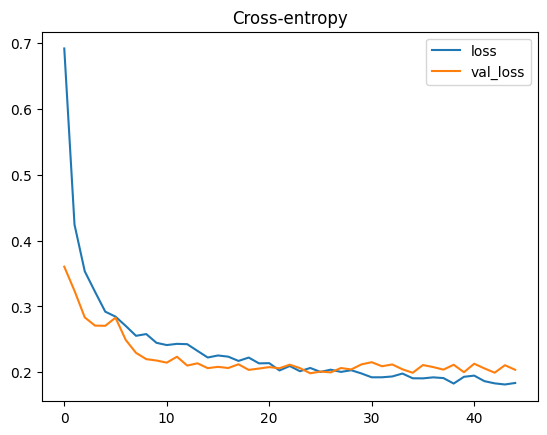

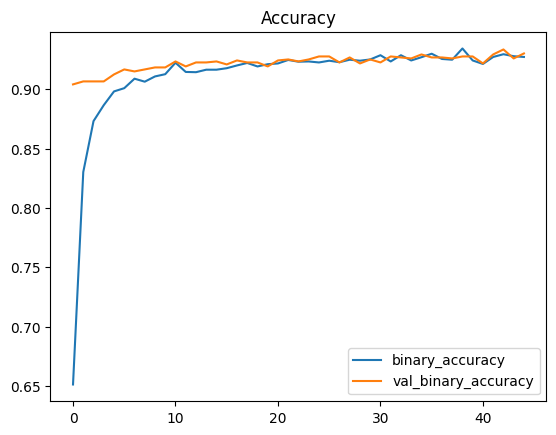

In [102]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [103]:
model.save('testmodel-1.keras')